# Notebook 7: Solution: Flexible Job Shop Scheduling with Genetic Algorithms
In this module we will explore planning of process chains using AI-based approaches. The problem we are looking at is the flexible job shop problem. Here, jobs and their associated operations must be assigned to the available machines in order to minimize throughput time. Traditionally, this is done using priority rules. AI-based approaches include the use of reinforcement learning or genetic algorithms. In this module, we will use genetic algorithms (GA) to solve the problem.

## Step 1: Define Simulation Parameters

In this step, we set up the basic parameters of our job shop simulation. We define the number of machines, jobs, and tasks per job. Each task may have constraints specifying which machines it can run on.  

We also define a penalty factor to be applied if a task is assigned to a machine that violates its constraints.  

- Number of machines: 6
- Number of jobs: 5
- Number of tasks per job: 5
-  Penalty factor for constraint violations: 10

Next, we generate random task durations for each job. This simulates real-world variability in task times and will be used later by the GA to optimize the schedule.  

Finally, we print the task sequences so that you can inspect them and compare with the expected format.


In [1]:
import random

# Simulation parameters
NUM_MACHINES = 6  # Number of machines in the shop
NUM_JOBS = 5      # Number of jobs
TASKS_PER_JOB = 5 # Number of tasks per job
PENALTY_FACTOR = 10  # Penalty multiplier for constraint violations

# Machine constraints for each task (example)
machine_constraints = {
    0: [0, 1, 3],   # Task 0 can only run on Machine 0 or 1
    1: [1, 2, 3],   # Task 1 can only run on Machine 1 or 2
    2: [3, 4],      # Task 2 can only run on Machine 0 or 2
    3: [4, 5],      # Task 3 can run on Machine 4 or 5
    4: [0, 5]       # Task 4 can run on Machine 0 or 5
}

# Generate random task durations for each job and task
job_task_sequences = [
    [random.randint(5, 15) for _ in range(TASKS_PER_JOB)] for _ in range(NUM_JOBS)
]

print(f'Task sequences: {job_task_sequences}') # Print the task sequence

Task sequences: [[8, 7, 11, 9, 13], [12, 15, 14, 15, 11], [10, 10, 13, 15, 5], [6, 6, 7, 5, 15], [6, 14, 14, 6, 11]]


## Step 2: Simulation Environment

Here, we set up the simulation environment using **SimPy**, a discrete-event simulation framework.  
Each machine is modeled as a resource with a capacity of 1, meaning it can only process one task at a time.  

The `process_task` method simulates the processing of a single task on a specific machine.  
It checks whether the assigned machine is allowed for that task. If not, the task duration is increased by the penalty factor.  

This setup allows the simulation to realistically account for machine availability and constraints.

In [2]:
import simpy

class FlexibleJobShop:
    def __init__(self, env, num_machines):
        self.env = env
        self.machines = [simpy.Resource(env, capacity=1) for _ in range(num_machines)]

    def process_task(self, job_id, task_id, machine_id, duration):
        """Simulate processing a task on a specific machine."""
        with self.machines[machine_id].request() as request:
            yield request
            
            # Check constraints and apply penalty if violated
            if machine_id not in machine_constraints[task_id]:
                duration *= PENALTY_FACTOR
            
            yield self.env.timeout(duration)


## Step 3: Job and Schedule Functions


This step defines the functions to simulate jobs and the overall schedule.  

- `job()` simulates a single job by iterating over its tasks and requesting the assigned machines in sequence.  
- `generate_jobs()` creates all jobs in the environment and schedules them to run concurrently.  
- `simulate_schedule()` starts the simulation and calculates the total production time, or makespan.  

The makespan is a critical metric for the GA because it will serve as the fitness measure: shorter makespans are better.

In [3]:
def job(env, job_id, shop, task_sequence, machine_schedule):
    """Simulate a single job."""
    for task_id, (duration, machine_id) in enumerate(zip(task_sequence, machine_schedule)):
        yield env.process(shop.process_task(job_id, task_id, machine_id, duration))

def generate_jobs(env, shop, job_task_sequences, job_machine_schedules):
    """Generate jobs based on predefined task sequences and machine schedules."""
    for job_id, (task_sequence, machine_schedule) in enumerate(zip(job_task_sequences, job_machine_schedules)):
        yield env.process(job(env, job_id, shop, task_sequence, machine_schedule))

def simulate_schedule(env, shop, job_task_sequences, job_machine_schedules):
    """Simulate the schedule and calculate the makespan."""
    env.process(generate_jobs(env, shop, job_task_sequences, job_machine_schedules))
    env.run()
    return env.now

## Step 4: Decode GA Solutions

Each candidate solution from the genetic algorithm represents a flat sequence of machine assignments for all tasks.  

We need to decode this linear array into a 2D matrix with dimensions (jobs × tasks). This ensures that each task in each job is assigned a specific machine during the simulation.  

Without decoding, the simulation cannot correctly interpret the GA solution.

In [4]:
def decode_solution(solution):
    """
    Decode the solution into a machine schedule.
    Each gene in the solution represents a machine assignment for a task.
    """
    job_machine_schedules = []
    index = 0

    for _ in range(NUM_JOBS):
        machine_schedule = []
        for _ in range(TASKS_PER_JOB):
            machine_schedule.append(int(solution[index]))
            index += 1
        job_machine_schedules.append(machine_schedule)
    
    return job_machine_schedules



## Step 5: Fitness Function

The fitness function evaluates each GA candidate solution by simulating the schedule in SimPy.  

It calculates the makespan, taking into account penalties for constraint violations.  

The GA tries to **maximize** the fitness, so we return the negative makespan: shorter schedules result in higher fitness values.  
This function connects the GA optimization to the simulation model.


In [5]:
def fitness_function(ga_instance, solution, solution_idx):
    """
    Fitness function to evaluate a schedule.
    Penalizes constraint violations and calculates makespan.
    """
    env = simpy.Environment()
    shop = FlexibleJobShop(env, NUM_MACHINES)

    job_machine_schedules = decode_solution(solution)
    makespan = simulate_schedule(env, shop, job_task_sequences, job_machine_schedules)
    
    # Return negative makespan as fitness (since PyGAD maximizes fitness)
    return -makespan

## Step 6: GA Configuration and Execution

Now we configure the genetic algorithm using **PyGAD**.  

We define the number of generations, the number of parents for mating, and the population size. The number of genes corresponds to the total number of tasks across all jobs.  

After running the GA, we obtain an optimized machine schedule and the corresponding best fitness.  

We can also visualize how the fitness evolved across generations to analyze GA convergence.

In [14]:
import pygad

# GA Configuration
num_genes = NUM_JOBS * TASKS_PER_JOB
gene_space = list(range(NUM_MACHINES)) # Each gene represents a valid machine ID

ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=num_genes,
    gene_space=gene_space,
)

Finally, we can run the optimization. Since task durations are generated randomly, results may vary if the notebook is run repeatedly.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimized Machine Schedule: [[3, 1, 4, 5, 5], [1, 3, 4, 4, 0], [0, 1, 3, 5, 5], [0, 3, 3, 5, 0], [3, 2, 4, 5, 0]]
Best Fitness (Negative Makespan): -258


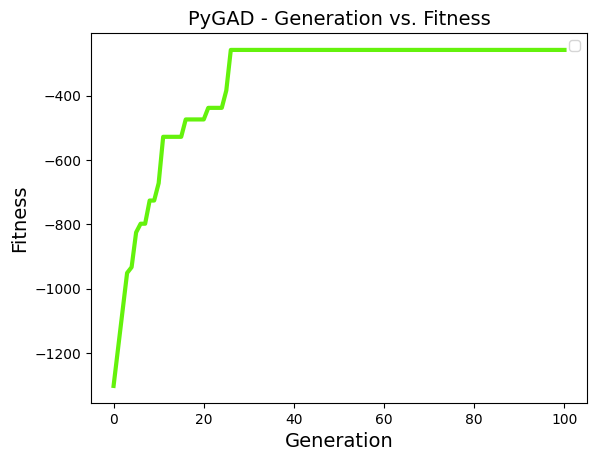

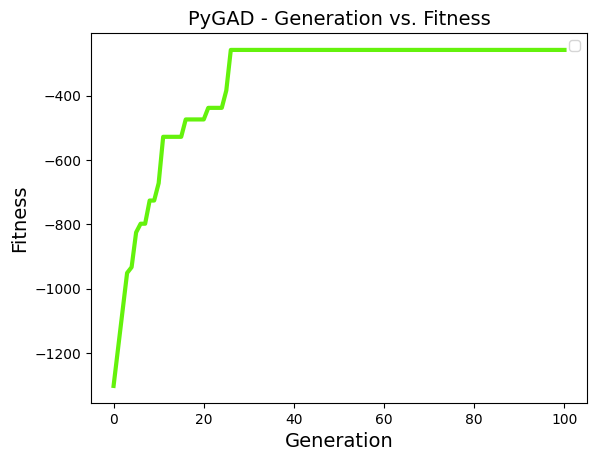

In [15]:
# Run the Genetic Algorithm
ga_instance.run()

# Get the best solution found by GA
best_solution = ga_instance.best_solution()[0]
best_fitness = ga_instance.best_solution()[1]

# Decode and display the best solution
optimized_schedule = decode_solution(best_solution)
print("Optimized Machine Schedule:", optimized_schedule)
print("Best Fitness (Negative Makespan):", best_fitness)

# Plot the fitness over generations
ga_instance.plot_fitness()